In [96]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm.pandas()
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from scipy.stats.stats import pearsonr 
from statistics import NormalDist
from imblearn.over_sampling import RandomOverSampler


In [5]:
train_df=pd.read_csv('./Data/train.csv')

In [6]:
target_values=train_df['y'].unique()

In [7]:
Ric_subjects=[]
epsi=1/116
for index,row in tqdm(train_df.iterrows()):
    subject = np.array(row[5:]).reshape((116, 115)).astype(float)
    corr = np.corrcoef(subject)
    Ric=np.zeros((116,116))
    corr_pos=np.fmax(corr,epsi)
    for i in range(0,116):
        for j in range(i,116):
            val=2-corr_pos[i,j]*(np.sum(1/(np.sqrt(corr_pos[i,j]*corr_pos[i])))+np.sum(1/(np.sqrt(corr_pos[i,j]*corr_pos[j]))))
            Ric[i,j]=val
            Ric[j,i]=val
    Ric_subjects.append(np.mean(Ric,axis=1))

0it [00:00, ?it/s]C:\Users\Nicola\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Nicola\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
600it [05:25,  1.84it/s]


In [8]:
Ric_subjects_arr=np.array(Ric_subjects)
avg=Ric_subjects_arr.mean(axis=0)
usable_roi=avg>=np.median(avg)
#ROI=np.array([f'ROI{i}' for i in range(1,117)])
#ROI[avg>=np.median(avg)]

In [168]:
m_ricci = []
for v in tqdm(range(len(target_values))):
    corr=[]
    df_y = train_df[train_df['y']==target_values[v]].iloc[:, 5:]
    for i in range(0,116):
        if usable_roi[i]:
            roi_i=df_y.iloc[:,i*115:(i+1)*115]
            for j in range(i+1,116):
                if usable_roi[j]:
                    roi_j=df_y.iloc[:,(j)*115:(j+1)*115]
                    corr.append(pearsonr(roi_i.values.flatten(),roi_j.values.flatten())[0])
    m_ricci.append(corr)
m_ricci = np.array(m_ricci)


100%|██████████| 99/99 [01:42<00:00,  1.03s/it]


In [169]:
m_ricci.shape

(99, 1653)

In [170]:
def get_corr(row,usable_roi,test=False):
    if test:
        brain = np.array(row[4:])
    else:
        brain = np.array(row[5:])
    #brain = brain.reshape((116, 115)).astype(float)
    #corr = np.corrcoef(brain)
    #flat = corr[np.triu_indices(corr.shape[0], 1)]
    corr = []
    for i in range(0,116):
        if usable_roi[i]:
            roi_i=brain[i*115:(i+1)*115]
            for j in range(i+1,116):
                if usable_roi[j]:
                    roi_j=brain[(j)*115:(j+1)*115]
                    corr.append(pearsonr(roi_i.flatten(), roi_j.flatten())[0])
    return corr


In [171]:
corr_df_train=pd.DataFrame(m_ricci).fillna(0)
corr_df_train['y']=target_values

# Train

In [172]:
X_train, X_test, y_train, y_test = train_test_split(corr_df_train.drop(columns='y'), corr_df_train['y'], test_size=0.25, random_state=42)


In [173]:
X_train.shape

(74, 1653)

In [105]:
sm = RandomOverSampler(random_state=42)
y_train_pos = np.digitize(y_train, y_train.sort_values().unique())
X_res, y_res = sm.fit_resample(X_train, y_train_pos)
X_train, y_train = X_res, y_train.sort_values().unique()[y_res-1]


In [106]:
X_train.shape

(74, 1653)

## SVR

In [127]:
#params = [{'kernel' : ['poly'],
#        'C' : [1,5,10,12,15,20,25],
#        'degree' : [2,3,4],
#        'coef0' : [0.02,0.5],
#        'gamma' : ['auto','scale'],
#        'epsilon':[0.02]}]

params = [{'kernel' : ['rbf'],
        'C' : [100,150,200],
        'gamma' : ['auto','scale'],
        'epsilon':[0.02]}]


In [128]:
svr_reg=SVR()
grids = GridSearchCV(svr_reg,params,cv=5,verbose=5,n_jobs=-1)
grids.fit(X_train,y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid=[{'C': [100, 150, 200], 'epsilon': [0.02],
                          'gamma': ['auto', 'scale'], 'kernel': ['rbf']}],
             verbose=5)

In [129]:
grids.best_params_

{'C': 100, 'epsilon': 0.02, 'gamma': 'scale', 'kernel': 'rbf'}

In [130]:
y_pred=grids.predict(X_test)
mean_squared_error(y_test, y_pred,squared=False)

19.435131569207236

In [131]:
#retrain on all dataset
#svr_reg=SVR(C= 10, degree= 2, kernel= 'poly')
#svr_reg=SVR(C= 10, degree= 3, kernel= 'poly',gamma='scale',coef0=0.5
#svr_reg=SVR(C= 15, degree= 3, kernel= 'poly',gamma='scale',coef0=0.5,epsilon=0.02)

svr_reg=SVR(**grids.best_params_)
svr_reg.fit(corr_df_train.drop(columns='y'),corr_df_train['y'])

SVR(C=100, epsilon=0.02)

In [174]:
from sklearn.neural_network import MLPRegressor

In [209]:
regr = MLPRegressor(random_state=1, max_iter=1000,hidden_layer_sizes=(100,20,30,30,30,20,100),alpha=0.01)
regr.fit(X_train, y_train)
y_pred_nn=regr.predict(X_test)
mean_squared_error(y_test, y_pred_nn,squared=False)

24.731883401577186

In [193]:
regr.fit(corr_df_train.drop(columns='y'),corr_df_train['y'])

MLPRegressor(alpha=0.5, hidden_layer_sizes=(100, 50, 30, 10), max_iter=1000,
             random_state=1)

# Linear models

In [76]:
from sklearn import linear_model
from sklearn.linear_model import Ridge,Lasso,MultiTaskLasso,Lars,BayesianRidge,RANSACRegressor,TheilSenRegressor,HuberRegressor
clf = TheilSenRegressor()

In [138]:
clf.fit(X_train, y_train)
y_pred_2=clf.predict(X_test)
mean_squared_error(y_test, y_pred_2,squared=False)

21.63169916742998

In [139]:
clf.fit(corr_df_train.drop(columns='y'),corr_df_train['y'])

TheilSenRegressor(max_subpopulation=10000)

# Test 

In [184]:
test_df=pd.read_csv('./Data/test.csv')

In [185]:
corr_test=test_df.progress_apply(lambda row:get_corr(row,usable_roi,test=True),axis=1)

  2%|▏         | 3/199 [00:01<02:08,  1.52it/s]C:\Users\Nicola\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
100%|██████████| 199/199 [01:53<00:00,  1.75it/s]


In [187]:
test_final_df=pd.DataFrame(np.array(corr_test.values.tolist())).fillna(0)

In [194]:
#y_pred_test_svr=svr_reg.predict(test_final_df)
#y_pred_test_ten=clf.predict(test_final_df)
y_pred_test_nn=regr.predict(test_final_df)

(array([ 6., 32., 47., 61., 36., 12.,  3.,  1.,  0.,  1.]),
 array([ 56.35426839,  72.33576185,  88.3172553 , 104.29874876,
        120.28024221, 136.26173567, 152.24322912, 168.22472257,
        184.20621603, 200.18770948, 216.16920294]),
 <BarContainer object of 10 artists>)

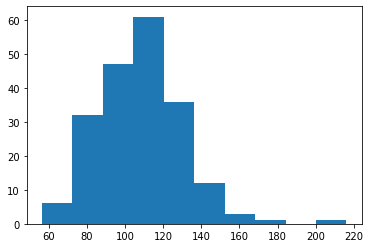

In [195]:
plt.hist(y_pred_test_nn)

(array([ 4.,  7., 18., 38., 40., 36., 27., 13., 11.,  5.]),
 array([ 63.93048703,  72.40871197,  80.88693692,  89.36516186,
         97.84338681, 106.32161176, 114.7998367 , 123.27806165,
        131.75628659, 140.23451154, 148.71273648]),
 <BarContainer object of 10 artists>)

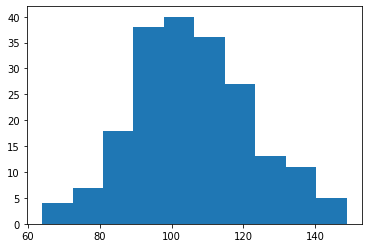

In [142]:
plt.hist(y_pred_test_ten)

In [89]:
y_pred_avg=0.6*y_pred_test_svr+0.4*y_pred_test_ten

In [196]:
y_pred_test_nn

array([ 91.01958021,  86.87812487, 107.62399608,  87.63864217,
        91.70855554, 131.11237735, 102.36880391, 112.64836539,
        88.83819423, 108.99817563, 117.07302242, 135.28726952,
        98.59245168, 154.07744924, 126.57961317,  99.26943518,
       114.56017856, 108.76199331, 117.78285557, 137.23065129,
       143.71655368, 101.30832029, 112.87064931, 107.09920828,
       127.80451068, 122.12518814, 117.60761149, 147.17868176,
       107.63807266, 125.79878179, 109.7249138 , 121.73597143,
       147.63713973, 111.82963667, 169.24361651, 154.08287968,
       119.03089022, 105.49243132,  95.64262667,  94.5511226 ,
        92.13833903, 135.81386058, 126.36176374,  83.46558429,
       120.15409694, 110.07717304, 129.15830486,  90.08806544,
        92.57921185,  95.4918722 , 216.16920294, 115.3475786 ,
       127.43762174, 129.93137063, 151.60839774, 115.57346961,
       103.31514638, 124.94832967, 106.31884113,  87.50889628,
       101.05974114,  82.09508694,  92.15225089, 125.48

In [91]:
df_leaderboard=pd.DataFrame({'id':test_df['id'],'target':y_pred_avg})

In [92]:
df_leaderboard.to_csv('G14_26_avg_models',index=False)

(array([2., 1., 1., 3., 2., 0., 1., 3., 1., 0., 3., 2., 0., 1., 3., 0., 1.,
        0., 0., 1.]),
 array([ 75.05723571,  78.02473113,  80.99222654,  83.95972196,
         86.92721738,  89.8947128 ,  92.86220822,  95.82970364,
         98.79719905, 101.76469447, 104.73218989, 107.69968531,
        110.66718073, 113.63467615, 116.60217157, 119.56966698,
        122.5371624 , 125.50465782, 128.47215324, 131.43964866,
        134.40714408]),
 <BarContainer object of 20 artists>)

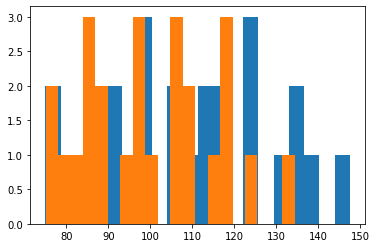

In [203]:
plt.hist(y_test, bins=20)
#plt.hist(y_pred, bins=20)
plt.hist(y_pred_nn, bins=20);


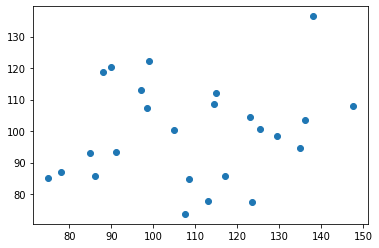

In [210]:
plt.scatter(y_test, y_pred_nn)
#plt.scatter(y_test, y_pred_2)


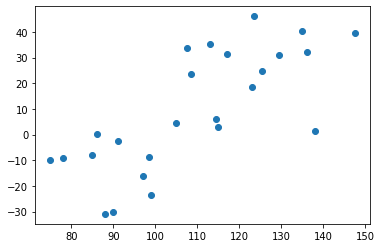

In [211]:
plt.scatter(y_test, (y_test-y_pred_nn))
#plt.scatter(y_test, (y_test-y_pred_2))
#plt.scatter(y_test, (y_test-(0.6*y_pred+0.4*y_pred_2)))


In [79]:
for i in np.arange(0,1,0.01):
    print(i,mean_squared_error(y_test, i*y_pred+(1-i)*y_pred_2,squared=False))

0.0 21.15634742207624
0.01 21.113671266384554
0.02 21.071358580130696
0.03 21.029411557294615
0.04 20.987832390359873
0.05 20.946623269914795
0.06 20.905786384246984
0.07 20.865323918931413
0.08 20.825238056411983
0.09 20.785530975576798
0.1 20.746204851327132
0.11 20.707261854140206
0.12 20.668704149625945
0.13 20.630533898077708
0.14 20.5927532540172
0.15 20.55536436573365
0.16 20.51836937481737
0.17 20.481770415687897
0.18 20.44556961511678
0.19 20.409769091745236
0.2 20.37437095559678
0.21 20.339377307585067
0.22 20.304790239017024
0.23 20.27061183109157
0.24 20.236844154394035
0.25 20.203489268386505
0.26 20.17054922089429
0.27 20.13802604758877
0.28 20.10592177146679
0.29 20.07423840232687
0.3 20.042977936242444
0.31 20.012142355032406
0.32 19.981733625729184
0.33 19.951753700044634
0.34 19.922204513833986
0.35000000000000003 19.89308798655814
0.36 19.864406020744596
0.37 19.836160501447317
0.38 19.808353295705754
0.39 19.780986252003448
0.4 19.754061199726397
0.41000000000000003

In [145]:
ROI=np.array([f'ROI{i}' for i in range(1,117)])[avg>=np.median(avg)]


In [154]:
ROI

array(['ROI1', 'ROI3', 'ROI4', 'ROI5', 'ROI7', 'ROI8', 'ROI9', 'ROI10',
       'ROI11', 'ROI12', 'ROI13', 'ROI19', 'ROI20', 'ROI21', 'ROI33',
       'ROI34', 'ROI35', 'ROI36', 'ROI45', 'ROI46', 'ROI50', 'ROI51',
       'ROI52', 'ROI53', 'ROI54', 'ROI59', 'ROI60', 'ROI61', 'ROI62',
       'ROI65', 'ROI66', 'ROI67', 'ROI68', 'ROI69', 'ROI70', 'ROI71',
       'ROI72', 'ROI85', 'ROI86', 'ROI87', 'ROI88', 'ROI90', 'ROI95',
       'ROI96', 'ROI101', 'ROI102', 'ROI103', 'ROI104', 'ROI105',
       'ROI106', 'ROI107', 'ROI108', 'ROI109', 'ROI110', 'ROI113',
       'ROI114', 'ROI115', 'ROI116'], dtype='<U6')

In [152]:
columns=[ROI[i]+'-'+ROI[j] for i in range(0,len(ROI)-1) for j in range(i+1,len(ROI))]

In [212]:
(corr_df_train['y'] > 100) & (corr_df_train['y'] < 120)


0      True
1      True
2      True
3      True
4     False
      ...  
94    False
95    False
96    False
97    False
98    False
Name: y, Length: 99, dtype: bool

In [214]:
(y_train > 100) & (y_train < 120)


33    False
9     False
81     True
11    False
65    False
      ...  
60     True
71    False
14    False
92    False
51    False
Name: y, Length: 74, dtype: bool